In [1]:
''' import '''
import scipy.io as io
import numpy as np
import numpy.linalg as la
import scipy.sparse as sp
import matplotlib.pyplot as plt

In [2]:
''' load data '''
data = io.loadmat('./data/hw3_prob2.mat')

f_orig = data['f']
x_orig = data['x_orig']

M, N = f_orig.shape

In [3]:
''' function '''
def soft_thres(z, t):
    return np.sign(z)*np.maximum(np.abs(z) - t, 0)

# ADMM (1d)

In [4]:
''' TV (D_h, D_v) '''
# no-pading
# Im = sp.eye(M)
# Dn = sp.diags([-1, 1], offsets=(0, 1), shape=(N-1, N))
# D_h = sp.kron(Im, Dn)

# In = sp.eye(N)
# Dm = sp.diags([-1, 1], offsets=(0, 1), shape=(M-1, M))
# D_v = sp.kron(Dm, In)

# padding
Im = sp.eye(M)
Dn = sp.diags([1, -1, 1], offsets=(-(N-1), 0, 1), shape=(N,N))
D_h = sp.kron(Im, Dn)

In = sp.eye(N)
Dm = sp.diags([1, -1, 1], offsets=(-(M-1), 0, 1), shape=(M,M))
D_v = sp.kron(Dm, In)

In [5]:
''' hyper param '''
MU = 0.02
LAMBDA = 0.0002
MAXITERS = 1000
CRIT = 1e-4

In [6]:
''' ADMM (1d) '''

fn_admm = []
xn_admm = []

f = f_orig.reshape(-1,1)
x = np.zeros((M*N,1))
x_prev = x

d_h = np.zeros((M*N,1))
q_h = np.zeros((M*N,1))
d_v = np.zeros((M*N,1))
q_v = np.zeros((M*N,1))

for k in range(MAXITERS):

    # f
    fn = (MU/2)*la.norm(x - f)**2 + la.norm(d_h, 1) + la.norm(d_v, 1) \
        + (LAMBDA/2)*la.norm(d_h - D_h@x - q_h)**2 + (LAMBDA/2)*la.norm(d_v - D_v@x - q_v)**2

    # update
    x = f + (LAMBDA/MU)*(D_h.T@(d_h - D_h@x - q_h) + D_v.T@(d_v - D_v@x - q_v))
    # x = MU*f/(MU + 4*LAMBDA) + LAMBDA/(MU + 4*LAMBDA)*(D_vh(x) + D_h.T@(d_h - q_h) + D_v.T@(d_v - q_v))

    d_h = soft_thres(D_h@x + q_h, 1/LAMBDA)
    d_v = soft_thres(D_v@x + q_v, 1/LAMBDA)
    q_h = q_h + (D_h@x - d_h)
    q_v = q_v + (D_v@x - d_v)

    # stop condition
    xcon = la.norm(x - x_prev)/la.norm(x)
    if (k >= 1) and (la.norm(x - x_prev)/la.norm(x) < CRIT):
        break
    
    x_prev = x

    # history
    fn_admm.append(fn)
    xn_admm.append(xcon)
    print(f'i = {k:<4d}, |x-x|/|x| = {xcon:.8f}, f = {fn:.8f}')

# optimal
x_admm = x

i = 0   , |x-x|/|x| = 1.00000000, f = 41338790.55061270
i = 1   , |x-x|/|x| = 0.02705183, f = 795476.25768850
i = 2   , |x-x|/|x| = 0.01082255, f = 1647487.85636805
i = 3   , |x-x|/|x| = 0.01117327, f = 2811054.60519039
i = 4   , |x-x|/|x| = 0.01064818, f = 4230905.16487931
i = 5   , |x-x|/|x| = 0.01004826, f = 5860382.35107355
i = 6   , |x-x|/|x| = 0.00852872, f = 7246631.08375861
i = 7   , |x-x|/|x| = 0.00797991, f = 8238086.39810726
i = 8   , |x-x|/|x| = 0.00651635, f = 9000069.99547473
i = 9   , |x-x|/|x| = 0.00584516, f = 9699454.03042018
i = 10  , |x-x|/|x| = 0.00529220, f = 10413058.15806158
i = 11  , |x-x|/|x| = 0.00500430, f = 11147261.21946597
i = 12  , |x-x|/|x| = 0.00477059, f = 11898828.53780266
i = 13  , |x-x|/|x| = 0.00455438, f = 12663771.48658541
i = 14  , |x-x|/|x| = 0.00435005, f = 13438565.75457943
i = 15  , |x-x|/|x| = 0.00415903, f = 14219958.40449087
i = 16  , |x-x|/|x| = 0.00397431, f = 15005602.96497821
i = 17  , |x-x|/|x| = 0.00380070, f = 15793073.84981044
i 

In [7]:
''' ADMM + reweighted L1 (1d) '''

DELTA = 3.9

fn_admm_rew = []
xn_admm_rew = []

f = f_orig.reshape(-1,1)
delta_list = np.linspace(0.2, 1, 12)

x = x_admm
x_prev = x

d_h = np.zeros((M*N,1))
q_h = np.zeros((M*N,1))
d_v = np.zeros((M*N,1))
q_v = np.zeros((M*N,1))

W_h = np.ones((M*N,1))
W_v = np.ones((M*N,1))

for k in range(MAXITERS):

    # f
    fn = (MU/2)*la.norm(x - f)**2 + la.norm(d_h, 1) + la.norm(d_v, 1) \
        + (LAMBDA/2)*la.norm(d_h - W_h*(D_h@x) - q_h)**2 + (LAMBDA/2)*la.norm(d_v - W_v*(D_v@x) - q_v)**2

    # update
    x = f + (LAMBDA/MU)*(D_h.T@(W_h*(d_h - W_h*(D_h@x) - q_h)) + D_v.T@(W_v*(d_v - W_v*(D_v@x) - q_v)))
    # x = MU*f/(MU + 4*LAMBDA) + LAMBDA/(MU + 4*LAMBDA)*(D_vh@x + D_h.T@(d_h - q_h) + D_v.T@(d_v - q_v))

    d_h = soft_thres(W_h*(D_h@x) + q_h, 1/LAMBDA)
    d_v = soft_thres(W_v*(D_v@x) + q_v, 1/LAMBDA)
    q_h = q_h + (W_h*(D_h@x) - d_h)
    q_v = q_v + (W_v*(D_v@x) - d_v)

    W_h = 1 / (np.abs(d_h) + DELTA)
    W_v = 1 / (np.abs(d_v) + DELTA)

    # stop condition
    xcon = la.norm(x - x_prev)/la.norm(x)
    if (k >= 1) and (xcon < CRIT):
        break
    
    x_prev = x

    # history
    fn_admm_rew.append(fn)
    xn_admm_rew.append(xcon)
    print(f'i = {k:<4d}, |x-x|/|x| = {xcon:.8f}, f = {fn:.8f}')

# optimal
x_admm_rew = x

i = 0   , |x-x|/|x| = 0.19256955, f = 1655279.30854869
i = 1   , |x-x|/|x| = 0.00667654, f = 305545.16115498
i = 2   , |x-x|/|x| = 0.00087626, f = 440875.48037862
i = 3   , |x-x|/|x| = 0.00086271, f = 603054.49654094
i = 4   , |x-x|/|x| = 0.00086012, f = 790105.02435581
i = 5   , |x-x|/|x| = 0.00085749, f = 1001844.87555109
i = 6   , |x-x|/|x| = 0.00085488, f = 1238094.08741238
i = 7   , |x-x|/|x| = 0.00085227, f = 1498674.10619875
i = 8   , |x-x|/|x| = 0.00084968, f = 1783407.77846764
i = 9   , |x-x|/|x| = 0.00084709, f = 2092119.33974068
i = 10  , |x-x|/|x| = 0.00084452, f = 2424634.40327442
i = 11  , |x-x|/|x| = 0.00084195, f = 2780779.94892474
i = 12  , |x-x|/|x| = 0.00083939, f = 3160384.31210407
i = 13  , |x-x|/|x| = 0.00085696, f = 3563039.77519362
i = 14  , |x-x|/|x| = 0.00117852, f = 3984589.65352075
i = 15  , |x-x|/|x| = 0.00176712, f = 4418993.53922826
i = 16  , |x-x|/|x| = 0.00316936, f = 4834033.79638444
i = 17  , |x-x|/|x| = 0.00430709, f = 5211779.58556332
i = 18  , |x-x

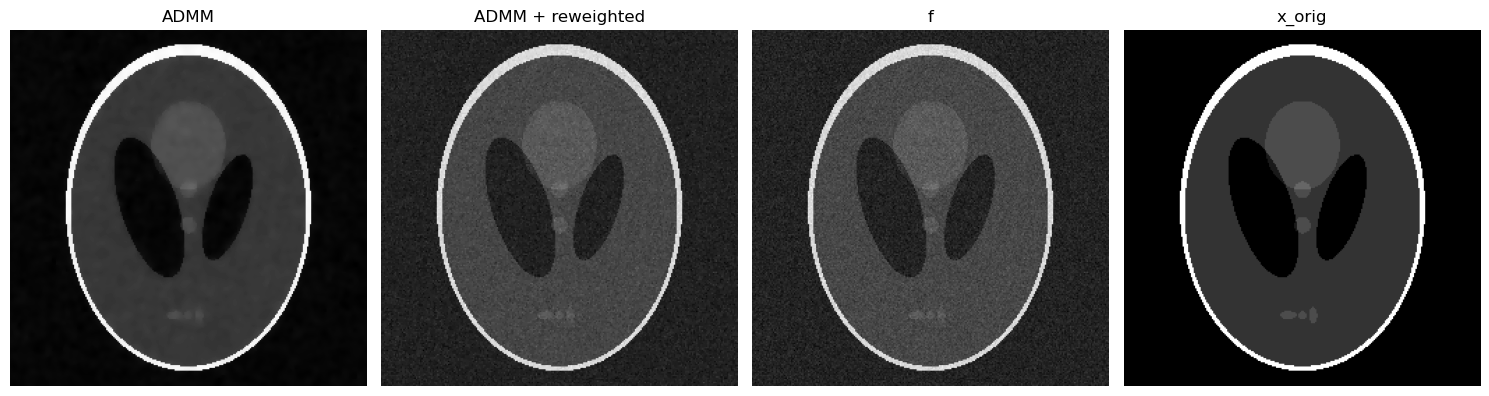

In [8]:
''' plot '''
_, axs = plt.subplots(1,4, figsize=(15,5))
axs[0].imshow(x_admm.reshape(M,N), cmap='gray')
axs[0].set_title('ADMM')
axs[0].axis('off')

axs[1].imshow(x_admm_rew.reshape(M,N), cmap='gray')
axs[1].set_title('ADMM + reweighted')
axs[1].axis('off')

axs[2].imshow(f_orig, cmap='gray')
axs[2].set_title('f')
axs[2].axis('off')

axs[3].imshow(x_orig, cmap='gray')
axs[3].set_title('x_orig')
axs[3].axis('off')

plt.tight_layout()
plt.show()

In [9]:
# ''' find delta : reweighted L1 (ADMM)  '''

# MAXITERS = 300
# DELTA = 3.9

# fn_hist = []
# xn_hist = []
# x_hist = []

# f = f_orig.reshape(-1,1)
# delta_list = np.linspace(0.2, 1, 12)

# for delta in delta_list:

#     x = x_admm
#     x_prev = x

#     d_h = np.zeros((M*N,1))
#     q_h = np.zeros((M*N,1))
#     d_v = np.zeros((M*N,1))
#     q_v = np.zeros((M*N,1))

#     W_h = np.ones((M*N,1))
#     W_v = np.ones((M*N,1))

#     for k in range(MAXITERS):

#         # f
#         fn = (MU/2)*la.norm(x - f)**2 + la.norm(d_h, 1) + la.norm(d_v, 1) \
#             + (LAMBDA/2)*la.norm(d_h - W_h*(D_h@x) - q_h)**2 + (LAMBDA/2)*la.norm(d_v - W_v*(D_v@x) - q_v)**2

#         # update
#         x = f + (LAMBDA/MU)*(D_h.T@(W_h*(d_h - W_h*(D_h@x) - q_h)) + D_v.T@(W_v*(d_v - W_v*(D_v@x) - q_v)))
#         # x = MU*f/(MU + 4*LAMBDA) + LAMBDA/(MU + 4*LAMBDA)*(D_vh@x + D_h.T@(d_h - q_h) + D_v.T@(d_v - q_v))

#         d_h = soft_thres(W_h*(D_h@x) + q_h, 1/LAMBDA)
#         d_v = soft_thres(W_v*(D_v@x) + q_v, 1/LAMBDA)
#         q_h = q_h + (W_h*(D_h@x) - d_h)
#         q_v = q_v + (W_v*(D_v@x) - d_v)

#         W_h = 1 / (np.abs(d_h) + delta)
#         W_v = 1 / (np.abs(d_v) + delta)

#         # stop condition
#         xcon = la.norm(x - x_prev)/la.norm(x)
#         if (k >= 1) and (xcon < CRIT):
#             break
        
#         x_prev = x

#     # history
#     fn_hist.append(fn)
#     xn_hist.append(xcon)
#     x_hist.append(x)
#     print(f'delta = {delta:.2f}, i = {k:<4d}, |x-x|/|x| = {xcon:.6f}, f = {fn:.2f}')


In [10]:
# # argmin
# fn_min_idx = np.argmin(fn_hist[:30])
# xn_min_idx = np.argmin(xn_hist[:30])

# print(f'fn_min : {delta_list[fn_min_idx]:.3f}')
# print(f'xn_min : {delta_list[xn_min_idx]:.3f}')

In [11]:
# # plot graph
# _, axs = plt.subplots(2,1, sharex=True, figsize=(10,5))
# axs[0].semilogy(fn_hist, label='f')
# # axs[0].vlines(fn_min_idx, min(fn_hist), max(fn_hist), colors='red', linestyles='--', label='$\\delta=0.4$')
# axs[0].set_ylabel('$f$')
# axs[0].legend()
# axs[0].grid()

# axs[1].semilogy(xn_hist, label='$|x_k - x_{k-1}|_2/|x_k|_2$')
# # axs[1].vlines(xn_min_idx, 0, max(xn_hist), colors='red', linestyles='--', label='$\\delta=0.5$')
# axs[1].set_ylabel('$|x-x|/|x|$')
# axs[1].set_xlabel('$\\delta$')
# axs[1].legend()
# axs[1].grid()

# plt.show()

In [12]:
# # plot images
# num_img = len(x_hist)
# cols = 6
# rows = (num_img + cols - 1) // cols

# fig, axs = plt.subplots(rows, cols, figsize=(15, 2.6 * rows))

# for i, ax in enumerate(axs.flat):
#     if i < num_img:
#         ax.imshow(x_hist[i].reshape(M,N), cmap='gray')
#         ax.set_title(f'$\\delta={delta_list[i]:.2f}$')
#         ax.axis('off')
#     else:
#         ax.axis('off')

# plt.tight_layout()
# plt.show()

# ADMM (1d)
D_h + D_v = D

In [13]:
''' TV (D_h, D_v) '''
D = sp.vstack([D_h, D_v])   # [D_h, D_v] -> 하나로 처리

In [14]:
''' ADMM (1d) '''

fn_admm2 = []
xn_admm2 = []

f = f_orig.reshape(-1,1)
x = np.zeros((M*N,1))
x_prev = x

d = np.zeros((2*(M*N),1))
q = np.zeros((2*(M*N),1))

for k in range(MAXITERS):

    # f
    fn = (MU/2)*la.norm(x - f)**2 + la.norm(d, 1) + (LAMBDA/2)*la.norm(d - D@x - q)**2

    # update
    x = f + (LAMBDA/MU)*(D.T@(d - D@x - q))

    d = soft_thres(D@x + q, 1/LAMBDA)
    q = q + (D@x - d)

    # stop condition
    xcon = la.norm(x - x_prev)/la.norm(x)
    if (k >= 1) and (la.norm(x - x_prev)/la.norm(x) < CRIT):
        break
    
    x_prev = x

    # history
    fn_admm2.append(fn)
    xn_admm2.append(xcon)
    print(f'i = {k:<4d}, |x-x|/|x| = {xcon:.8f}, f = {fn:.8f}')

# optimal
x_admm2 = x

i = 0   , |x-x|/|x| = 1.00000000, f = 41338790.55061270
i = 1   , |x-x|/|x| = 0.02705183, f = 795476.25768851
i = 2   , |x-x|/|x| = 0.01082255, f = 1647487.85636806
i = 3   , |x-x|/|x| = 0.01117327, f = 2811054.60519039
i = 4   , |x-x|/|x| = 0.01064818, f = 4230905.16487932
i = 5   , |x-x|/|x| = 0.01004826, f = 5860382.35107357
i = 6   , |x-x|/|x| = 0.00852872, f = 7246631.08375857
i = 7   , |x-x|/|x| = 0.00797991, f = 8238086.39810726
i = 8   , |x-x|/|x| = 0.00651635, f = 9000069.99547471
i = 9   , |x-x|/|x| = 0.00584516, f = 9699454.03042028
i = 10  , |x-x|/|x| = 0.00529220, f = 10413058.15806170
i = 11  , |x-x|/|x| = 0.00500430, f = 11147261.21946600
i = 12  , |x-x|/|x| = 0.00477059, f = 11898828.53780266
i = 13  , |x-x|/|x| = 0.00455438, f = 12663771.48658535
i = 14  , |x-x|/|x| = 0.00435005, f = 13438565.75457949
i = 15  , |x-x|/|x| = 0.00415903, f = 14219958.40449093
i = 16  , |x-x|/|x| = 0.00397431, f = 15005602.96497812
i = 17  , |x-x|/|x| = 0.00380070, f = 15793073.84981051
i 

In [15]:
''' ADMM + reweighted L1 (1d) '''

DELTA = 3.9

fn_admm_rew2 = []
xn_admm_rew2 = []

f = f_orig.reshape(-1,1)
x = x_admm2
x_prev = x

d = np.zeros((2*(M*N),1))
q = np.zeros((2*(M*N),1))
W = np.ones((2*(M*N),1))

for k in range(MAXITERS):

    # f
    fn = (MU/2)*la.norm(x - f)**2 + la.norm(d, 1) + (LAMBDA/2)*la.norm(d - W*(D@x) - q)**2

    # update
    x = f + (LAMBDA/MU)*(D.T@(d - W*(D@x) - q))

    d = soft_thres(W*(D@x) + q, 1/LAMBDA)
    q = q + (W*(D@x) - d)
    W = 1 / (d + DELTA)

    # stop condition
    xcon = la.norm(x - x_prev)/la.norm(x)
    if (k >= 1) and (la.norm(x - x_prev)/la.norm(x) < CRIT):
        break
    
    x_prev = x

    # history
    fn_admm_rew2.append(fn)
    xn_admm_rew2.append(xcon)
    print(f'i = {k:<4d}, |x-x|/|x| = {xcon:.8f}, f = {fn:.8f}')

# optimal
x_admm_rew2 = x

i = 0   , |x-x|/|x| = 0.19256955, f = 1655279.30854869
i = 1   , |x-x|/|x| = 0.01149127, f = 305545.16115498
i = 2   , |x-x|/|x| = 0.00311368, f = 441108.20381608
i = 3   , |x-x|/|x| = 0.00316584, f = 597770.32053620
i = 4   , |x-x|/|x| = 0.00312758, f = 776575.92516440
i = 5   , |x-x|/|x| = 0.00309128, f = 976818.01073580
i = 6   , |x-x|/|x| = 0.00305546, f = 1197899.88614727
i = 7   , |x-x|/|x| = 0.00302014, f = 1439241.10498659
i = 8   , |x-x|/|x| = 0.00298531, f = 1700278.66095588
i = 9   , |x-x|/|x| = 0.00295096, f = 1980466.41763498
i = 10  , |x-x|/|x| = 0.00291710, f = 2279274.58973143
i = 11  , |x-x|/|x| = 0.00288370, f = 2596189.24011539
i = 12  , |x-x|/|x| = 0.00285078, f = 2930711.79279488
i = 13  , |x-x|/|x| = 0.00281832, f = 3282358.56129723
i = 14  , |x-x|/|x| = 0.00278466, f = 3650330.26225408
i = 15  , |x-x|/|x| = 0.00274591, f = 4030410.33371221
i = 16  , |x-x|/|x| = 0.00272550, f = 4418845.48295040
i = 17  , |x-x|/|x| = 0.00271265, f = 4786525.18807198
i = 18  , |x-x|